<a href="https://colab.research.google.com/github/g12bftd/AI-ML-Paper-Implementations/blob/main/HierarchicalTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch einops lightning timm hierarchicalforecast datasetsforecast "gluonts[mxnet,pro]"

INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

In [2]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 115.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.3.1 which is incompatible.
mxnet 1.9.1 requires numpy<2.0.0,>1.16.0, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.1 which is incomp

In [1]:
from __future__ import annotations
from typing import Optional, Tuple, List, Dict, Final
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
from timm.layers import DropPath, trunc_normal_
from hierarchicalforecast.evaluation import scaled_crps, rel_mse, msse
from datasetsforecast.hierarchical import HierarchicalInfo, HierarchicalData
from gluonts.dataset.hierarchical import HierarchicalTimeSeries
import numpy as np
import pandas as pd
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt

In [57]:
def build_scaler(method: str, eps: float = 1e-8):
    """
    Returns
    -------
    scale(x, dim, return_stats=False)
        → scaled tensor (and stats if requested)
    unscale(x, stats)
        → tensor in original units
    """

    if method == "none":
        def scale(x, dim, return_stats=False):
            return (x, None) if return_stats else x
        def unscale(x, stats):
            return x

    elif method in {"standard", "gaussian"}:
        # z‑score:  (x − μ) / σ
        def scale(x, dim, return_stats=False):
            μ = x.mean(dim=dim, keepdim=True)
            σ = x.std(dim=dim, keepdim=True) + eps
            x_hat = (x - μ) / σ
            return (x_hat, (μ, σ)) if return_stats else x_hat

        def unscale(x, stats):
            μ, σ = stats
            return x * σ + μ

    elif method in {"minmax", "0-1"}:
        # (x − min) / (max − min)
        def scale(x, dim, return_stats=False):
            xmin = x.amin(dim=dim, keepdim=True)
            xmax = x.amax(dim=dim, keepdim=True)
            rng = (xmax - xmin).clamp_min(eps)
            x_hat = (x - xmin) / rng
            return (x_hat, (xmin, rng)) if return_stats else x_hat

        def unscale(x, stats):
            xmin, rng = stats
            return x * rng + xmin

    else:
        raise ValueError(
            f"Unknown scaling method '{method}'. "
            "Choose from 'none', 'standard', or 'minmax'."
        )

    return scale, unscale


def empirical_crps(samples: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
    N = samples.size(0)
    # |samples - obs|
    term1 = torch.abs(samples - obs).mean(dim=0)            # (...)

    # |samples_i - samples_j|
    dists = torch.abs(samples.unsqueeze(0) - samples.unsqueeze(1))  # (N,N,...)
    term2 = 0.5 * dists.mean(dim=(0, 1))                    # (...)

    crps = (term1 - term2).mean()                           # scalar
    return crps

class VanillaAttention(nn.Module):
    def __init__(self, dim, heads, attn_drop=0.0, proj_drop=0.0, qkv_bias=True):
        super().__init__()
        assert dim % heads == 0
        self.h = heads
        self.dh = dim // heads
        self.scale = self.dh ** -0.5

        self.qkv = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        B, N, D = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.h, self.dh)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)
        attn = (q * self.scale) @ k.transpose(-2, -1)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float("-inf"))
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

class AlternatingAttention(nn.Module):
    """
    Alternates attention axis every other block:
        • Even‑indexed blocks (block_idx % 2 == 0) attend **across series**
          (“series‑wise” attention).
        • Odd‑indexed  blocks attend **across timesteps** (“time‑wise” attention).

    Parameters
    ----------
    dim          : int   -- embedding dimension
    heads        : int   -- number of attention heads
    num_series   : int   -- count of bottom‑level series in the panel / hierarchy
    block_idx    : int   -- position of the block in the stack (0‑based)
    attn_drop    : float -- dropout on attention weights
    proj_drop    : float -- dropout on the projected output
    qkv_bias     : bool  -- add bias term in qkv projection
    """
    def __init__(
        self,
        dim: int,
        heads: int,
        num_series: int,
        block_idx: int,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        qkv_bias: bool = True,
    ):
        super().__init__()
        self.num_series = num_series
        self.series_first = block_idx % 2 == 0        # even → series attention
        self.inner = VanillaAttention(
            dim, heads, attn_drop=attn_drop, proj_drop=proj_drop, qkv_bias=qkv_bias
        )

    def forward(self, x, mask=None):
        """
        x    : (B, N, D)  with N = num_series * T
        mask : (B, N) optional binary keep‑mask (not axis‑specific)
        """
        B, N, D = x.shape
        S = self.num_series
        assert N % S == 0, "Sequence length N must be divisible by num_series"
        T = N // S

        if self.series_first:
            # -- series‑wise attention -----------------------------------
            # group by timestep → (B*T, S, D) then restore
            x = rearrange(x, "b (s t) d -> (b t) s d", s=S)
            if mask is not None:
                mask = rearrange(mask, "b (s t) -> (b t) s", s=S)
            x = self.inner(x, mask)
            x = rearrange(x, "(b t) s d -> b (s t) d", t=T)
        else:
            # -- time‑wise attention -------------------------------------
            # group by series → (B*S, T, D) then restore
            x = rearrange(x, "b (s t) d -> (b s) t d", s=S)
            if mask is not None:
                mask = rearrange(mask, "b (s t) -> (b s) t", s=S)
            x = self.inner(x, mask)
            x = rearrange(x, "(b s) t d -> b (s t) d", s=S)

        return x



class TransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        heads,
        mlp_ratio=4.,
        drop_path=0.,
        attn_drop=0.,
        proj_drop=0.,
        attention_type="vanilla",
        num_series=1,
        block_idx=0,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        if attention_type == "vanilla":
            self.attn = VanillaAttention(dim, heads, attn_drop, proj_drop)
        elif attention_type == "alternating":
            self.attn = AlternatingAttention(
                dim, heads, num_series, block_idx, attn_drop, proj_drop
            )
        else:
            raise ValueError(attention_type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        hid = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hid),
            nn.GELU(),
            nn.Dropout(proj_drop),
            nn.Linear(hid, dim),
            nn.Dropout(proj_drop),
        )

    def forward(self, x, mask=None):
        x = x + self.drop_path(self.attn(self.norm1(x), mask))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class HierarchicalTransformer(pl.LightningModule):
    def __init__(
        self,
        S,
        *,
        mode: str = "pointwise",
        num_encoder_layers: int = 2,
        num_decoder_layers: int = 2,
        attention_type: str = "alternating",
        scaling: str = "standard",
        num_samples_for_loss: int = 50,
        context_length: int = 24,
        prediction_length: int = 12,
        embed_dim: int = 128,
        num_heads: int = 8,
        mlp_ratio: float = 4.,
        dropout: float = 0.1,
        lr: float = 2e-4,
    ):
        super().__init__()
        assert mode in {"pointwise", "probabilistic"}
        self.mode = mode
        self.register_buffer("S", torch.as_tensor(S).float(), persistent=False)
        self.num_bottom_series = S.shape[1]
        self.num_total_series  = S.shape[0]
        self.context_length = context_length
        self.pred_length = prediction_length
        self.scaling_mode = scaling               # keep the name of the method
        self._scale, self._unscale = build_scaler(self.scaling_mode)
        self.lr = lr
        self.num_samples = num_samples_for_loss

        # embeddings
        self.in_proj = nn.Linear(1, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_length, embed_dim))
        trunc_normal_(self.pos_emb, std=0.02)
        nn.init.xavier_uniform_(self.in_proj.weight)
        nn.init.constant_(self.in_proj.bias, 0.)

        # encoder / decoder
        self.encoder = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, num_heads, mlp_ratio, dropout,
                    attn_drop=dropout, proj_drop=dropout,
                    attention_type=attention_type,
                    num_series=self.num_total_series,
                    block_idx=i,
                )
                for i in range(num_encoder_layers)
            ]
        )
        self.dec_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, num_heads, mlp_ratio, dropout,
                    attn_drop=dropout, proj_drop=dropout,
                    attention_type=attention_type,
                    num_series=self.num_bottom_series,
                    block_idx=i + num_encoder_layers,
                )
                for i in range(num_decoder_layers)
            ]
        )
        self.enc_norm = nn.LayerNorm(embed_dim)
        self.dec_norm = nn.LayerNorm(embed_dim)

        # heads
        self.mu_head = nn.Linear(embed_dim, 1)
        if mode == "probabilistic":
            self.log_sigma_head = nn.Linear(embed_dim, 1)

        self.mse = nn.MSELoss()

        self.max_context = self.context_length + self.pred_length
        self.temporal_emb = nn.Parameter(
            torch.zeros(1, self.max_context, embed_dim)      # (1,  T_max,  D)
        )
        self.series_emb = nn.Parameter(
            torch.zeros(1, self.num_total_series, embed_dim)       # (1,  S,      D)
        )
        trunc_normal_(self.temporal_emb, std=0.02)
        trunc_normal_(self.series_emb, std=0.02)

    # ---------------------- helpers ------------------------------------- #
    def _encode(self, seq: torch.Tensor) -> torch.Tensor:
        B, T, S = seq.shape
        #print(f"Input sequence shape: {seq.shape}")
        x = self.in_proj(seq.view(B, T * S, 1))
        #print(f"x shape after input projection: {x.shape}")

        # temporal: repeat each timestep embedding for every series
        pos_time = self.temporal_emb[:, :T, :].repeat_interleave(S, dim=1)

        # series: repeat the S series embeddings for every timestep
        pos_series = (
            self.series_emb[:, :S, :].repeat(1, T, 1)       # (1, T*S, D)
            .view(1, T * S, -1)
        )

        #print(f"pos_time shape: {pos_time.shape}, pos_series shape: {pos_series.shape}")

        pos = pos_time + pos_series

        #print(f"pos shape: {pos.shape}")

        x = x + pos
        for blk in self.encoder:
          x = blk(x)

        return self.enc_norm(x)                               # (B, N, D)

    def _decode_steps(self, mem: torch.Tensor) -> torch.Tensor:
        """Greedy AR decode -> μ_t (B, P, S)"""
        B, N, D = mem.shape
        S = self.num_bottom_series
        last = mem[:, -S:, :]                                 # (B,S,D)
        mus = []
        sigs = []
        for _ in range(self.pred_length):
            x = last
            for blk in self.dec_blocks: x = blk(x)
            x = self.dec_norm(x)
            mus.append(self.mu_head(x).squeeze(-1))           # (B,S)
            if self.mode == "probabilistic":
                sigs.append(F.softplus(self.log_sigma_head(x)).squeeze(-1))
            last = self.in_proj(mus[-1].unsqueeze(-1))
        mu = torch.stack(mus, 1)                              # (B,P,S)
        if self.mode == "probabilistic":
            sigma = torch.stack(sigs, 1)                      # (B,P,S)
            return mu, sigma
        return mu, None

    def _bottom_up(self, y_bottom: torch.Tensor) -> torch.Tensor:
        """
        y_bottom : (B, P, S_bottom)
        returns  : (B, P, S_total)
        """
        S = self.S                                           # (total, bottom)
        #print(f"S shape: {S.shape}, y_bottom.shape: {y_bottom.shape}")
        y = torch.einsum("ij, ... pj -> ... pi", S, y_bottom)      # bottom‑up
        return y

    # ---------------------- forward ------------------------------------- #
    def forward(
                self,
                past_target: torch.Tensor,            # (B, T_ctx, S_bottom)
                future_target: Optional[torch.Tensor] = None,
                train: bool = False):

      # Scale context and keep running stats
      past_scaled, stats = self._scale(past_target, dim=1, return_stats=True)
      #print(f"past_scaled shape: {past_scaled.shape}")

      # teacher‑forcing: scale future with *same* stats
      if train and future_target is not None:
          if self.scaling_mode == "none":
              future_scaled = future_target
          elif self.scaling_mode in {"standard", "gaussian"}:
              μ, σ = stats
              future_scaled = (future_target - μ) / σ
          else:  # minmax
              xmin, rng = stats
              future_scaled = (future_target - xmin) / rng
      else:
          future_scaled = None


      if train and future_target is not None:
          mem_input = torch.cat([past_scaled, future_scaled], 1)
          mem = self._encode(mem_input)

          mu_full = self.mu_head(self.dec_norm(mem))          # (B, N, 1)
          #print(f"mu_full shape before view: {mu_full.shape}")

          B = mu_full.size(0)
          mu_full = mu_full.view(B, -1, self.num_total_series)
          #print(f"mu_full shape after view: {mu_full.shape}")

          mu_bottom = mu_full[:, -self.pred_length:, : self.num_bottom_series]
          #print(f"mu_bottom shape: {mu_bottom.shape}")

          if self.mode == "probabilistic":
              sigma_full = F.softplus(self.log_sigma_head(self.dec_norm(mem)))
              #print(f"sigma_full shape after softplus: {sigma_full.shape}")

              sigma_full = sigma_full.view(B, -1, self.num_total_series)
              #print(f"sigma_full shape after view: {sigma_full.shape}")

              sigma_bottom = sigma_full[:, -self.pred_length:, : self.num_bottom_series]
              #print(f"sigma_bottom shape: {sigma_bottom.shape}")
          else:
              sigma_bottom = None
      else:
          mu_bottom, sigma_bottom = self._decode_steps(self._encode(past_scaled))

      # Un-scale before reconciliation
      if self.scaling_mode != "none":
        if self.scaling_mode in {"standard", "gaussian"}:
            μ_ctx, σ_ctx = stats                # (B, 1, 89)
            μ_ctx_b = μ_ctx[..., : self.num_bottom_series]   # (B,1,56)
            σ_ctx_b = σ_ctx[..., : self.num_bottom_series]   # (B,1,56)
            mu_bottom = mu_bottom * σ_ctx_b + μ_ctx_b
            if sigma_bottom is not None:
                sigma_bottom = sigma_bottom * σ_ctx_b

        else:   # "minmax"
            xmin, rng = stats                   # (B,1,89) each
            xmin_b = xmin[..., : self.num_bottom_series]     # (B,1,56)
            rng_b  = rng[...,  : self.num_bottom_series]     # (B,1,56)
            mu_bottom = mu_bottom * rng_b + xmin_b
            if sigma_bottom is not None:
                sigma_bottom = sigma_bottom * rng_b


      # Reconciliation
      mu_all = self._bottom_up(mu_bottom)
      if self.mode == "pointwise":
          return mu_all

      # Sampling
      eps = torch.randn(
          self.num_samples, *sigma_bottom.shape, device=sigma_bottom.device
      )
      samples_bottom = mu_bottom.unsqueeze(0) + sigma_bottom.unsqueeze(0) * eps
      #print(f"samples_bottom shape before reconciliation: {samples_bottom.shape}")
      samples_all = self._bottom_up(samples_bottom)
      return mu_all, samples_all

    def training_step(self, batch, _):
      past      = batch["past_target_cdf"]           # (B, 28, 89)
      fut       = batch["future_target_cdf"]         # (B,  4, 89)
      past_msk  = batch["past_observed_values"]      # (B, 28, 89)
      fut_msk   = batch["future_observed_values"]    # (B,  4, 89)

      # ---- remove padding / missing tokens ---------------------------------
      past_clean = past * past_msk                   # zeros where mask==0
      fut_clean  = fut  * fut_msk                    # needed for teacher forcing

      # ---- forward (teacher forcing) ---------------------------------------
      if self.mode == "pointwise":
          preds_all = self(past_clean, fut_clean, train=True)  # (B,4,89)

          # masked MSE
          loss = F.mse_loss(
              preds_all[fut_msk == 1],
              fut_clean[fut_msk == 1],
              reduction="mean",
          )
      else:  # probabilistic
          mu_all, samples_all = self(past_clean, fut_clean, train=True)  # (N,B,4,89)
          samp = samples_all.reshape(self.num_samples, -1)
          obs  = fut_clean.reshape(-1)
          mask = fut_msk.reshape(-1) == 1
          loss = empirical_crps(samp[:, mask], obs[mask])

      self.log("train_loss", loss, prog_bar=True)
      return loss


    def validation_step(self, batch, _):
      past     = batch["future_target_cdf"]
      fut      = batch["future_target_cdf"]
      past_msk = batch["future_observed_values"]
      fut_msk  = batch["future_observed_values"]

      past_clean = past * past_msk

      if self.mode == "pointwise":
          preds_all = self(past_clean, train=False)           # (B,4,89)
          loss = F.mse_loss(preds_all[fut_msk == 1], fut[fut_msk == 1], reduction="mean")
      else:
          mu_all, samples_all = self(past_clean, train=False)  # (N,B,4,89)
          samp = samples_all.reshape(self.num_samples, -1)
          obs  = fut.reshape(-1)
          mask = fut_msk.reshape(-1) == 1
          loss = empirical_crps(samp[:, mask], obs[mask])

      self.log("val_loss", loss, prog_bar=True)
      return loss

    def predict_step(self, batch, _idx, _dl=None):
      past     = batch["future_target_cdf"]
      past_msk = batch["future_observed_values"]
      past_clean = past * past_msk

      if self.mode == "pointwise":
          mu_all = self(past_clean, train=False)          # (B, P, 89)
          return mu_all
      else:
          _, samples_all = self(past_clean, train=False)  # (N,B,P,89)
          return samples_all


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)



class EpochLossPlotter(Callback):
    def __init__(self):
        super().__init__()
        self.train_epoch_tot = 0.0
        self.train_epoch_cnt = 0
        self.train_hist = []
        self.val_hist   = []


    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        loss = outputs["loss"] if isinstance(outputs, dict) else outputs
        if torch.is_tensor(loss):
            self.train_epoch_tot += loss.item()
            self.train_epoch_cnt += 1


    def on_train_epoch_end(self, trainer, pl_module):
        if self.train_epoch_cnt:
            mean_loss = self.train_epoch_tot / self.train_epoch_cnt
            self.train_hist.append((trainer.current_epoch, mean_loss))
        self.train_epoch_tot = 0.0
        self.train_epoch_cnt = 0


    def on_validation_epoch_end(self, trainer, pl_module):
        val = trainer.callback_metrics.get("val_loss")
        if val is not None:
            self.val_hist.append((trainer.current_epoch, val.item()))


    def on_train_end(self, trainer, pl_module):
        if not self.train_hist:
            return

        plt.figure(figsize=(6, 4))

        e_tr, l_tr = zip(*self.train_hist)
        plt.plot(e_tr, l_tr, label="train", marker="o")

        if self.val_hist:
            e_val, l_val = zip(*self.val_hist)
            plt.plot(e_val, l_val, label="val", marker="s")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs. Epoch")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()





In [58]:
class HierarchicalDataset(object):

    available_datasets = ['Labour','Traffic',
                          'TourismSmall','TourismLarge','Wiki2',
                          'OldTraffic', 'OldTourismLarge']

    @staticmethod
    def _get_hierarchical_scrps(hier_idxs, Y, Yq_hat, q_to_pred):
        # We use the indexes obtained from the aggregation tags
        # to compute scaled CRPS across the hierarchy levels
        scrps_list = []
        for idxs in hier_idxs:
            y      = Y[idxs, :]
            yq_hat = Yq_hat[idxs, :, :]
            level_scrps  = scaled_crps(y, yq_hat, q_to_pred)
            scrps_list.append(level_scrps)
        return scrps_list

    @staticmethod
    def _get_hierarchical_msse(hier_idxs, Y, Y_hat, Y_train):
        # We use the indexes obtained from the aggregation tags
        # to compute MS scaled Error across the hierarchy levels
        msse_list = []
        for idxs in hier_idxs:
            y       = Y[idxs, :]
            y_hat   = Y_hat[idxs, :]
            y_train = Y_train[idxs, :]
            level_msse = msse(y, y_hat, y_train)
            msse_list.append(level_msse)
        return msse_list

    @staticmethod
    def _get_hierarchical_rel_mse(hier_idxs, Y, Y_hat, Y_train):
        # We use the indexes obtained from the aggregation tags
        # to compute relative MSE across the hierarchy levels
        rel_mse_list = []
        for idxs in hier_idxs:
            y       = Y[idxs, :]
            y_hat   = Y_hat[idxs, :]
            y_train = Y_train[idxs, :]
            level_rel_mse = rel_mse(y, y_hat, y_train)
            rel_mse_list.append(level_rel_mse)
        return rel_mse_list

    @staticmethod
    def _get_hierarchical_rel_bias(hier_idxs, Y, Y_hat, agg='mean', eps=1e-8):
        """
        Returns
        -------
        rel_bias_list : list[float]
            One scalar per hierarchy level (in *fractional* units, e.g. 0.05 = +5 %).
            Negative ⇒ under‑forecast; positive ⇒ over‑forecast.
        """
        rel_bias_list = []
        for idxs in hier_idxs:
            y      = Y[idxs, :]
            y_hat  = Y_hat[idxs, :]

            if agg == 'sum':
                # pooled‑sum MPE for the whole level
                num = (y_hat - y).sum()
                den = y.sum() + eps
                level_rel_bias = num / den
            else:
                series_rel_bias = np.mean((y_hat - y) / (y + eps), axis=1)
                level_rel_bias  = np.median(series_rel_bias) if agg == 'median' \
                                  else series_rel_bias.mean()

            rel_bias_list.append(level_rel_bias)

        return rel_bias_list

    @staticmethod
    def _sort_hier_df(Y_df, S_df):
        # NeuralForecast core, sorts unique_id lexicographically
        # deviating from S_df, this class matches S_df and Y_hat_df order.
        Y_df.unique_id = Y_df.unique_id.astype('category')
        Y_df.unique_id = Y_df.unique_id.cat.set_categories(S_df.index)
        Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
        return Y_df

    @staticmethod
    def _nonzero_indexes_by_row(M):
        return [np.nonzero(M[row,:])[0] for row in range(len(M))]

    @staticmethod
    def load_process_data(dataset, directory='./data'):
        # Load data
        data_info = HierarchicalInfo[dataset]
        Y_df, S_df, tags = HierarchicalData.load(directory=directory,
                                                 group=dataset)

        # Parse and augment data
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        Y_df = HierarchicalDataset._sort_hier_df(Y_df=Y_df, S_df=S_df)

        # Obtain indexes for plots and evaluation
        hier_levels = ['Overall'] + list(tags.keys())
        hier_idxs = [np.arange(len(S_df))] +\
            [S_df.index.get_indexer(tags[level]) for level in list(tags.keys())]
        hier_linked_idxs = HierarchicalDataset._nonzero_indexes_by_row(S_df.values.T)

        # Final output
        data = dict(Y_df=Y_df, S_df=S_df, tags=tags,
                    # Hierarchical idxs
                    hier_idxs=hier_idxs,
                    hier_levels=hier_levels,
                    hier_linked_idxs=hier_linked_idxs,
                    # Dataset Properties
                    horizon=data_info.papers_horizon,
                    freq=data_info.freq,
                    seasonality=data_info.seasonality)
        return data

In [59]:
DATASET = 'TourismSmall'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

data = HierarchicalDataset.load_process_data(dataset=DATASET)

S = data['S_df'].values
bottom_cols = data['S_df'].columns
prediction_length = data['horizon']

Y_bottom_df = data['Y_df'].pivot(index='ds', columns='unique_id',values='y')
Y_bottom_df = Y_bottom_df.loc[:, bottom_cols].to_period()

hts_train = HierarchicalTimeSeries(
    ts_at_bottom_level=Y_bottom_df.iloc[:-prediction_length, :],
    S=S)
hts_test = HierarchicalTimeSeries(
    ts_at_bottom_level=Y_bottom_df.iloc[-prediction_length:, :],
    S=S,
)

In [98]:
hts_train.ts_at_all_levels[:-4][:]

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
ds,,,,,,,,,,,,,,,,,,,,,
1998Q1,84503.0,45906.0,26042.0,9815.0,2740.0,17589.0,10412.0,9078.0,3089.0,3449.0,...,431,271,244,73,168,37,76,24,35,8
1998Q2,65312.0,29347.0,20676.0,11823.0,3466.0,11027.0,6025.0,6310.0,1935.0,2454.0,...,669,170,142,221,170,99,36,61,69,39
1998Q3,72753.0,32492.0,20582.0,13565.0,6114.0,8910.0,5060.0,11733.0,1569.0,3398.0,...,270,1164,397,315,380,1166,32,23,150,338
1998Q4,70880.0,31813.0,21613.0,11478.0,5976.0,10658.0,5481.0,8109.0,2270.0,3561.0,...,214,535,194,260,410,1139,48,43,172,453
1999Q1,86893.0,46793.0,26947.0,10027.0,3126.0,16152.0,10958.0,10047.0,3023.0,4287.0,...,458,557,147,33,162,28,77,60,15,47
1999Q2,66866.0,31442.0,19481.0,11875.0,4068.0,9840.0,5841.0,8088.0,2219.0,3905.0,...,364,555,342,129,125,161,70,90,72,63
1999Q3,72182.0,34623.0,20026.0,11713.0,5820.0,9265.0,5104.0,12553.0,1712.0,3729.0,...,935,1865,137,109,546,243,26,49,75,182
1999Q4,68318.0,31118.0,20431.0,10582.0,6187.0,10427.0,4774.0,9652.0,1940.0,2732.0,...,640,703,400,251,299,568,34,56,145,217
2000Q1,85651.0,47030.0,24284.0,9734.0,4603.0,16340.0,9972.0,10077.0,3282.0,5131.0,...,513,374,274,155,365,266,49,122,37,56


In [60]:
def plot_series(
        Y_test: np.ndarray,
        Y_hat:  np.ndarray,
        num_series_to_plot: int = 5,
        seed: int | None = None,
        figsize: tuple[int, int] = (10, 2)
    ) -> None:

    assert Y_test.shape == Y_hat.shape, "Shapes of Y_test and Y_hat must be exactly the same"
    n_series, n_steps = Y_test.shape
    num_series_to_plot = min(num_series_to_plot, n_series)

    rng = np.random.default_rng(seed)
    idxs = rng.choice(n_series, size=num_series_to_plot, replace=False)

    fig, axes = plt.subplots(
        num_series_to_plot, 1,
        figsize=(figsize[0], figsize[1] * num_series_to_plot),
        sharex=True
    )

    if num_series_to_plot == 1:
        axes = [axes]

    x = np.arange(1, n_steps + 1)

    for ax, i in zip(axes, idxs):
        ax.plot(x, Y_test[i], label="truth",  marker="o")
        ax.plot(x, Y_hat[i],  label="pred",   marker="s")
        ax.set_ylabel(f"series {i}")
        ax.grid(True, alpha=.3)

    axes[-1].set_xlabel("forecast horizon step")
    axes[0].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [61]:
import random
from pathlib import Path

class SavedExampleDataset(torch.utils.data.Dataset):
    def __init__(self, path: str | Path):
        self.examples: List[Dict[str, torch.Tensor]] = torch.load(path)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

def to_torch(x):
    """Return a *CPU* torch.Tensor, converting from MXNet NDArray or NumPy."""
    if isinstance(x, torch.Tensor):
        return x.cpu()
    #elif isinstance(x, mx.nd.NDArray):
        #return torch.from_numpy(x.as_in_context(mx.cpu()).asnumpy())
    elif isinstance(x, np.ndarray):
        return torch.from_numpy(x)
    else:
        raise TypeError(f"Unsupported array type: {type(x)}")


def simple_collate(batch):
    """Stack each field along dim 0. All examples already share shapes."""
    return {k: torch.stack([b[k] for b in batch]) for k in batch[0]}

def batch_to_torch(batch: Dict[str, object]) -> Dict[str, torch.Tensor]:
    """Convert every array in a batch dict to CPU torch.Tensor."""
    return {k: to_torch(v) for k, v in batch.items()}

def flatten_loader(loader) -> List[Dict[str, torch.Tensor]]:
    """
    Iterate once through a DataLoader (MXNet *or* PyTorch) and return a list
    with one dict *per example*.
    """
    examples: List[Dict[str, torch.Tensor]] = []
    for batch in loader:
        tbatch = batch_to_torch(batch)
        B = next(iter(tbatch.values())).shape[0]   # batch size
        for i in range(B):
            examples.append({k: t[i].clone() for k, t in tbatch.items()})
    return examples

def dataset_fingerprint(example: Dict[str, torch.Tensor]) -> Dict[str, tuple]:
    """A hashable summary: tensor shapes for every key in one example."""
    return {k: tuple(v.shape) for k, v in example.items()}



TRAIN_SAVE_PATH = "/content/train_examples.pt"
VAL_SAVE_PATH = "/content/val_examples.pt"
BATCH_SIZE = 32

train_ds = SavedExampleDataset(TRAIN_SAVE_PATH)
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=simple_collate,
)
examples_train      = flatten_loader(train_loader)
fingerprint_train   = dataset_fingerprint(examples_train[0])
count_train         = len(examples_train)

print("\n✅ Train checks passed")
print(f"  example count : {count_train}")
print(f"  shape fingerprint: {fingerprint_train}")

val_ds = SavedExampleDataset(VAL_SAVE_PATH)
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=simple_collate,
)

examples_val      = flatten_loader(val_loader)
fingerprint_val   = dataset_fingerprint(examples_val[0])
count_val         = len(examples_val)


print("\n✅ Val checks passed")
print(f"  example count : {count_val}")
print(f"  shape fingerprint: {fingerprint_val}")






✅ Train checks passed
  example count : 1600
  shape fingerprint: {'target_dimension_indicator': (89,), 'past_time_feat': (28, 2), 'past_target_cdf': (28, 89), 'past_observed_values': (28, 89), 'past_is_pad': (28,), 'future_time_feat': (4, 2), 'future_target_cdf': (4, 89), 'future_observed_values': (4, 89)}

✅ Val checks passed
  example count : 1
  shape fingerprint: {'target_dimension_indicator': (89,), 'past_time_feat': (28, 2), 'past_target_cdf': (28, 89), 'past_observed_values': (28, 89), 'past_is_pad': (28,), 'future_time_feat': (4, 2), 'future_target_cdf': (4, 89), 'future_observed_values': (4, 89)}


In [128]:
examples_train[0]['target_dimension_indicator']

for k, v in examples_train[0].items():
  print(k, v)

target_dimension_indicator tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88.])
past_time_feat tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        

Check this out for dataset creation: https://github.com/jgasthaus/gluon-ts/blob/master/src/gluonts/mx/model/deepar/_estimator.py

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | in_proj        | Linear     | 32     | train
1 | encoder        | ModuleList | 6.6 K  | train
2 | dec_blocks     | ModuleList | 6.6 K  | train
3 | enc_norm       | LayerNorm  | 32     | train
4 | dec_norm       | Lay

Training set has 1600 elements
Test set has 1 elements


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


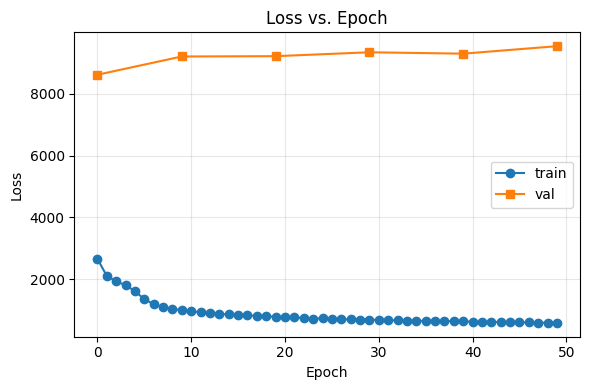

In [63]:
pl.seed_everything(42)

context_len = 28
prediction_len = 4

print(f"Training set has {len(train_loader.dataset)} elements")
print(f"Test set has {len(val_loader.dataset)} elements")

model = HierarchicalTransformer(
    S=S,
    mode="probabilistic", # "probabilistic" or "pointwise"
    context_length=context_len,
    prediction_length=prediction_len,
    attention_type="alternating", # "alternating" or "vanilla"
    embed_dim=16,
    num_heads=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    scaling="minmax" # or "standard", "minmax" or "none"
)

loss_cb = EpochLossPlotter()
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10,
    check_val_every_n_epoch=10,
    callbacks=[loss_cb]
)

trainer.fit(model, train_loader, val_loader)


In [64]:
samples = trainer.predict(model, val_loader)[0].squeeze(dim=1)
samples = samples.numpy()
Y_hat  = np.transpose(np.mean(samples, axis=0), (1,0))
Yq_hat = np.quantile(samples, q=QUANTILES, axis=0)
Yq_hat = np.transpose(Yq_hat, (2,1,0))

Y_test = hts_test.ts_at_all_levels[-prediction_length:].values # [Q,T,n_series]->[n_series,T,Q]
Y_test = np.transpose(Y_test, (1,0))

Y_train = hts_train.ts_at_all_levels.values # [Q,T,n_series]->[n_series,T,Q]
Y_train = np.transpose(Y_train, (1,0))

print(f"samples shape: {samples.shape}")
print(f"Y_hat shape: {Y_hat.shape}")
print(f"Yq_hat shape: {Yq_hat.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Y_train shape: {Y_train.shape}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

samples shape: (50, 4, 89)
Y_hat shape: (89, 4)
Yq_hat shape: (89, 4, 100)
Y_test shape: (89, 4)
Y_train shape: (89, 32)


## Evaluation

To evaluate we use the following metrics:

A scaled variation of the CRPS, as proposed by Rangapuram (2021), to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

$$ \mathrm{sCRPS}(\hat{F}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq $$


Relative mean squared error (RelMSE), as proposed by Hyndman & Koehler (2006) and used in Olivares (2023).

$$ \mathrm{RelMSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{\hat{y}}^{naive1}) =
\frac{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}})}{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}}^{naive1})} $$

Mean squared scaled error (MSSE), as proposed by Hyndman & Koehler (2006).

$$ \mathrm{MSSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{y}^{in-sample}) =
\frac{\frac{1}{h} \sum^{t+h}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^2}{\frac{1}{t-1} \sum^{t}_{\tau=2} (y_{\tau} - y_{\tau-1})^2}
$$

In [65]:
_scrps = HierarchicalDataset._get_hierarchical_scrps(Y=Y_test, Yq_hat=Yq_hat,
                                            hier_idxs=data['hier_idxs'],
                                            q_to_pred=QUANTILES)

_msse = HierarchicalDataset._get_hierarchical_msse(Y=Y_test, Y_hat=Y_hat,
                                           Y_train=Y_train,
                                           hier_idxs=data['hier_idxs'])

_rel_mse = HierarchicalDataset._get_hierarchical_rel_mse(Y=Y_test, Y_hat=Y_hat,
                                           Y_train=Y_train,
                                           hier_idxs=data['hier_idxs'])

_bias = HierarchicalDataset._get_hierarchical_rel_bias(hier_idxs=data['hier_idxs'],
                                                       Y=Y_test,
                                                       Y_hat=Y_hat)


results_df = pd.DataFrame(dict(level=['Overall']+list(data['tags'].keys())))
results_df['scrps'] = _scrps
results_df['rel_mse'] = _rel_mse
results_df['msse'] = _msse
results_df['rel_bias'] = _bias
results_df

/usr/local/lib/python3.11/dist-packages/hierarchicalforecast/evaluation.py:19: FutureWarning: This loss function (scaled_crps) will be deprecated in future releases. Please use the `utilsforecast.losses` function instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hierarchicalforecast/evaluation.py:19: FutureWarning: This loss function (mqloss) will be deprecated in future releases. Please use the `utilsforecast.losses` function instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hierarchicalforecast/evaluation.py:19: FutureWarning: This loss function (msse) will be deprecated in future releases. Please use the `utilsforecast.losses` function instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hierarchicalforecast/evaluation.py:19: FutureWarning: This loss function (mse) will be deprecated in future releases. Please use the `utilsforecast.losses` function instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hierarchicalforecast/eva

,level,scrps,rel_mse,msse,rel_bias
0,Overall,2.997409,349.788214,267.651019,7.607034
1,Country,2.934534,432.886095,299.278035,3.061534
2,Country/Purpose,2.947721,266.707221,238.264089,3.346217
3,Country/Purpose/State,3.030554,378.245767,272.446826,6.869824
4,Country/Purpose/State/CityNonCity,3.076826,318.582178,222.613407,8.361152


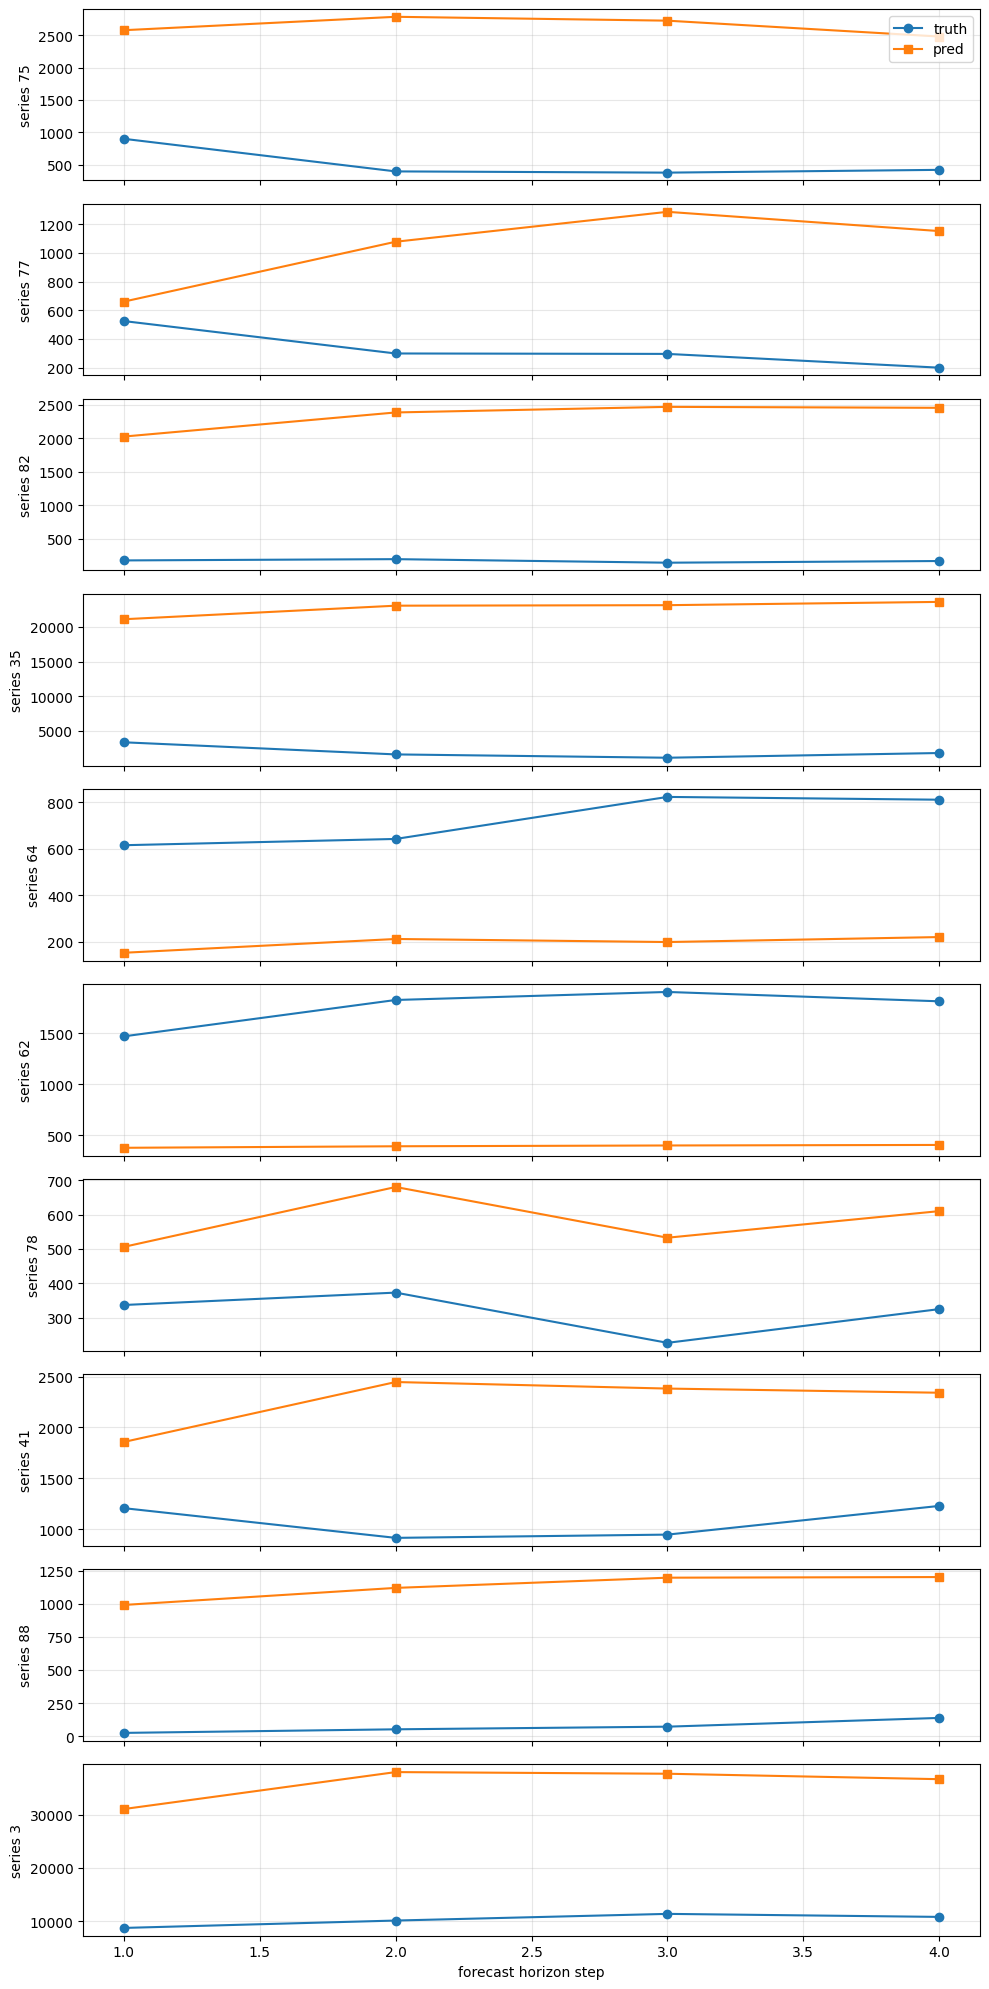

In [66]:
plot_series(Y_test, Y_hat, num_series_to_plot=10)